In [5]:
import os
import pandas as pd
import pickle
import random
import seaborn as sns
import matplotlib.ticker as ticker
from matplotlib import pyplot as plt


def gera_data():
    """ Lê arquivo .pkl e gera os dados utilizados pelo teste.

    Retorna:
    dict: Retorna um dicionário com o seguinte padrão: {Modulação: {SNR: [(MOS, BER, 'FEC', Code Rate)]}}.

    """

    a_file = open("data.pkl", "rb")
    return pickle.load(a_file)


def ord_maior_mos(lista_de_tuplas):
    """ Ordena uma lista de tuplas

    Parâmetros:
    Lista de tuplas (list): Lista contendo tuplas de quatro elementos de acordo
    com o seguinte padrão [(MOS, BER, FEC, Rate)]

    Retorna:
    list: Retorna a lista de tuplas, ordenada decrescente, com base no primeiro elemento de cada tupla (MOS)

    """

    return sorted(lista_de_tuplas, key=lambda element: element[0], reverse=True)


def ord_menor_rate(lista_de_tuplas):
    """ Ordena uma lista de tuplas

    Parâmetros:
    Lista de tuplas (list): Lista contendo tuplas de quatro elementos de acordo
    com o seguinte padrão [(MOS, BER, FEC, Rate)]

    Retorna:
    list: Retorna a lista de tuplas, ordenada decrescente, com base no quarto elemento de cada tupla (RATE).

    """
    return sorted(lista_de_tuplas, key=lambda element: element[3])


def gera_graficos(dataset, x, y, color):
    """ Retorna um gráfico baseado nas informações contidas no dataset recebido. """
    sns.set(style="whitegrid")
    ax = sns.lineplot(x=x, y=y, data=dataset, color=color)
    plt.ylim(0, 5)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))


class Parametros:
    def __init__(self, seed, tam_vetor_snr, a, b, qtd_chamadas, band, modulacao):
        self.seed = seed
        self.tam_vetor_snr = tam_vetor_snr
        self.a = a
        self.b = b
        self.qtd_chamadas = qtd_chamadas
        self.band = band
        self.modulacao = modulacao

    def gera_vetor_snr(self):
        """ Retorna um vetor do tamanho especificado com valores randomicos dentro do intervalo definido. """
        random.seed(self.seed)
        vetor_snr = []
        for i in range(0, self.tam_vetor_snr):
            vetor_snr.append(round(random.uniform(self.a, self.b), 1))
        return vetor_snr

    def calcula_banda_requerida(self, rate):
        """ Calcula a largura de banda necessária realizar uma chamada, de acordo com o codec G.711,
            considerando o codigo de correção (FEC) utilizado.
        """

        codec_payload = 160  # Bytes
        pps = 50  # Milisegundos
        cabecalho_ip = 40  # Bytes
        return (
            (((codec_payload * rate + cabecalho_ip) * 8) * pps) / 1000
        ) * self.qtd_chamadas

    def busca_resultados(self, snr):
        """ Faz uma busca no dicionário de dados e retorna uma lista de tuplas baseado nos parâmetros. """
        configs_disponiveis = []
        for mod, param in gera_data().items():
            if mod == self.modulacao:
                if snr in param.keys():
                    for tupla in param.get(snr):
                        rate = tupla[3]
                        if self.calcula_banda_requerida(rate) <= self.band:
                            configs_disponiveis.append(tupla)
        return configs_disponiveis

    def gera_dataset_resultado(self, lista_resultado, vetor_snr):
        """ Retorna as lista recebidas concatenadas em formato de dataset. """
        bandwidth_results = []
        for i in lista_resultado:
            rate = i[3]
            bandwidth_results.append(self.calcula_banda_requerida(rate))
        df0 = pd.DataFrame(bandwidth_results, columns=["BANDWIDTH"])
        df1 = pd.DataFrame(lista_resultado, columns=["MOS", "BER", "FEC", "RATE"])
        df2 = pd.DataFrame(vetor_snr, columns=["SNR"])
        df2["TIME"] = df2.reset_index().index
        return pd.concat([df2, df1, df0], axis=1, sort=False)


class Teste(Parametros):
    def modelo_adaptativo(self):
        results = []
        vetor_snr = []
        for snr in self.gera_vetor_snr():
            vetor_snr.append(snr)
            lista_de_tuplas = self.busca_resultados(snr)

            # Se maior resultado de MOS for menor do que 2.58,
            # retorna configuração com menor rate [prioridade largura de banda]

            if ord_maior_mos(lista_de_tuplas)[0][0] < 2.58:
                results.append(ord_menor_rate(lista_de_tuplas)[0])

            # Se maior resultado de MOS estiver maior do que 4.03, seleciona todas configurações com valor acima de
            # 4.03 e seleciona com menor rate [prioridade largura de banda]

            elif ord_maior_mos(lista_de_tuplas)[0][0] > 4.03:
                temp = []
                for tupla in lista_de_tuplas:
                    if tupla[0] > 4.03:
                        temp.append(tupla)
                results.append(ord_menor_rate(temp)[0])
                temp.clear()

            # Caso contrario é escolhido o maior resultado de MOS com o menor rate [prioridade MOS]

            else:
                results.append(
                    ord_maior_mos(ord_menor_rate(lista_de_tuplas))[0]
                )
        tabela_completa = self.gera_dataset_resultado(results, vetor_snr)
        print(
            "Banda média requerida =",
            round(tabela_completa["BANDWIDTH"].mean(), 4),
            "Kbp/s",
            "\n",
        )
        print("MOS médio =", round(tabela_completa["MOS"].mean(), 4), "\n")
        return gera_graficos(tabela_completa, "TIME", "MOS", "blue")

    def modelo_fixo(self, **kwargs):
        results = []
        vetor_snr = []
        if not kwargs.get("code"):
            pattern = "No Code"
        else:
            try:
                n = kwargs["n"]
                k = kwargs["k"]
            except:
                return []
            pattern = "RS(" + str(n) + ", " + str(k) + ")"
        for snr in self.gera_vetor_snr():
            vetor_snr.append(snr)
            for element in self.busca_resultados(snr):
                if element[2] == pattern:
                    results.append(element)
        tabela_completa = self.gera_dataset_resultado(results, vetor_snr)
        print(
            "Banda média requerida =",
            round(tabela_completa["BANDWIDTH"].mean(), 4),
            "Kbp/s",
            "\n",
        )
        print("MOS médio =", round(tabela_completa["MOS"].mean(), 4), "\n")
        return gera_graficos(tabela_completa, "TIME", "MOS", "green")


In [ ]:
    # def compara_modelos(self, **kwargs):
    #     test1 = self.modelo_adaptativo()
    #     test2 = self.modelo_fixo(**kwargs)
    #     return test1, test2

In [7]:
# Args: | Seed | Tamanho Vetor SNR | Valor inicial | Valor final | Modulação | Quantidade de Chamadas | Banda disponível
resultado = Teste(299, 30, 3, 30, 1, 100, 'BPSK')

Banda média requerida = 80.7802 Kbp/s 

MOS médio = 4.149 



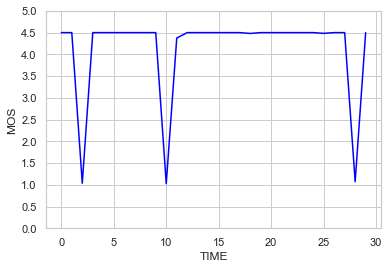

In [8]:
resultado.modelo_adaptativo()

Banda média requerida = 88.5333 Kbp/s 

MOS médio = 4.0707 



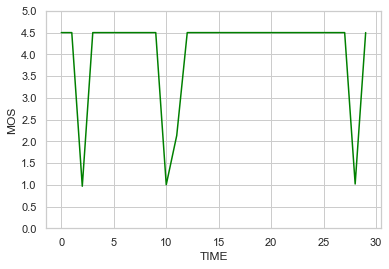

In [9]:
resultado.modelo_fixo(code=True, n=255, k=225)